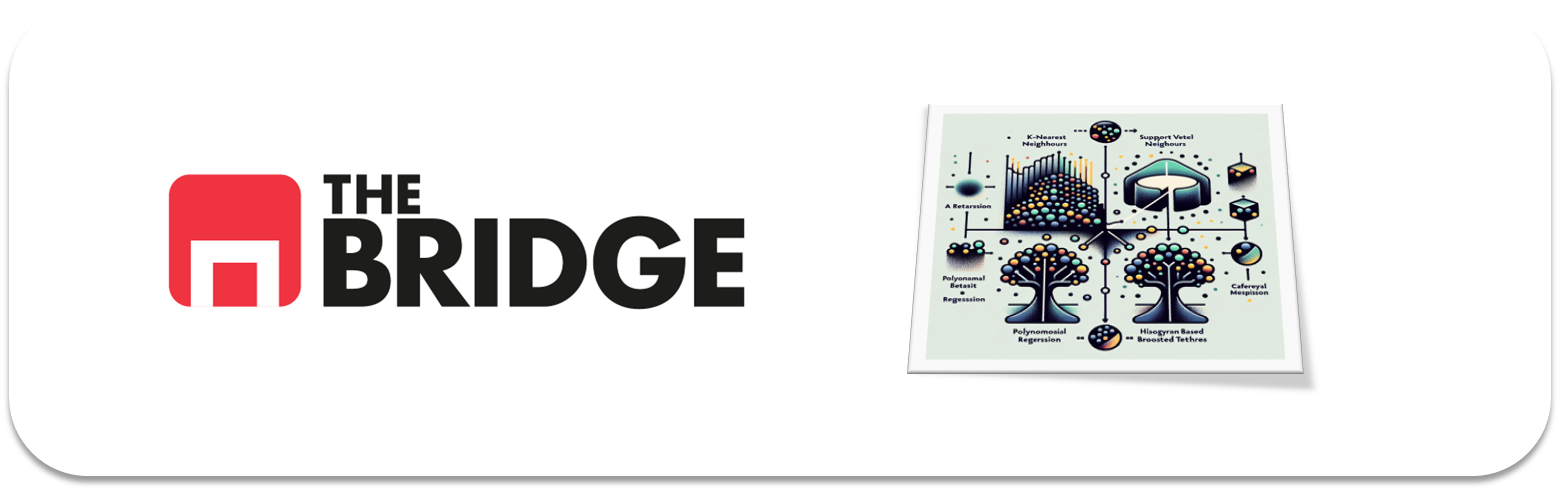

## PRACTICA OBLIGATORIA: **Repaso Aprendizaje Supervisado**

* La práctica obligatoria de esta unidad consiste en resolver sobre un mismo dataset un problema de clasificación y un problema de regresión. Descarga este notebook en tu ordenador y trabaja en local. Ten en cuenta que tendrás que descar los directorios de imágenes y datos adicionales, si los hubiera.
* Recuerda que debes subirla a tu repositorio personal antes de la sesión en vivo para que puntúe adecuadamente.  
* Recuerda también que no es necesario que esté perfecta, sólo es necesario que se vea el esfuerzo. 
* Esta práctica se resolverá en la sesión en vivo correspondiente y la solución se publicará en el repo del curso. 

### Ejercicio 0

Importa los paquetes y módulos que necesites a lo largo del notebook.

In [53]:
import bootcampviztools as bt
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
import seaborn as sns

from lightgbm import LGBMClassifier, LGBMRegressor
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, make_scorer, precision_score, ConfusionMatrixDisplay,mean_absolute_percentage_error
from sklearn.model_selection import cross_val_score, train_test_split, GridSearchCV
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import StandardScaler
from xgboost import XGBClassifier, XGBRegressor

### #1 Explicación del dataset y carga de datos

Vamos a trabajar con el dataset "Wine Quality", que es un dataset en el que se recogen diversas características fisicoquímicas de las variades tinta y blanca del "Vinho verde" portugués. Las variables del dataset se describen a continuación


1. **Acidez fija**: La mayoría de los ácidos involucrados con el vino son fijos o no volátiles (no se evaporan fácilmente).
2. **Acidez volátil**: La cantidad de ácido acético en el vino, que en niveles demasiado altos puede llevar a un sabor desagradable a vinagre.
3. **Ácido cítrico**: Encontrado en pequeñas cantidades, el ácido cítrico puede añadir 'frescura' y sabor a los vinos.
4. **Azúcar residual**: Es la cantidad de azúcar restante después de que se detiene la fermentación, es raro encontrar vinos con menos de 1 gramo/litro y vinos con más de 45 gramos/litro se consideran dulces.
5. **Cloruros**: La cantidad de sal en el vino.
6. **Dióxido de azufre libre**: La porción libre de SO2 existe en equilibrio entre el SO2 molecular (como un gas disuelto) y el ion bisulfito; previene el crecimiento microbiano y la oxidación del vino.
7. **Dióxido de azufre total**: Es la cantidad de formas libres y ligadas de S02; en bajas concentraciones, el SO2 es en su mayoría indetectable en el vino, pero en concentraciones libres de más de 50 ppm, el SO2 se hace evidente en la nariz y el sabor del vino.
8. **Densidad**: La densidad del vino es cercana a la del agua dependiendo del porcentaje de alcohol y contenido de azúcar.
9. **pH**: Describe qué tan ácido o básico es un vino en una escala de 0 (muy ácido) a 14 (muy básico); la mayoría de los vinos están entre 3-4 en la escala de pH.
10. **Sulfatos**: Un aditivo del vino que puede contribuir a los niveles de dióxido de azufre (SO2), que actúa como un antimicrobiano y antioxidante.
11. **Alcohol**: El porcentaje de contenido de alcohol del vino.
12. **Calidad**: Una variable de salida (basada en datos sensoriales, puntuación entre 0 y 10).
13. **Class**: Si es blanco o tinto.



Carga el dataset "wines_dataset.csv", muestra sus primeras filas, su información general y define dos variables target una para clasificación que permita predecir la calidad del vino según el resto de propiedas y otra variable target para regresión que permita predecir el grado alcohólico del vino a partir del resto de propiedades. 

El **objetivo de negocio en el primer problema** será anticipar la posible clasificación de sus vinos por los catadores profesionales y a partir de ahí poder planificar la producción, distribución y precio a poner a cada vino. En este sentido, el "cliente" nos dice que le gustaría poder clasificar correctamente lo mejor posible en media  (que interpretamos como el mejor recall medio posible).

El **objetivo de negocio en el segundo problema** (bastante artificial) es poder hacer simulaciones de posibles vinos futuros para saber cómo conseguir variedades más o menos alcohólicas para atender mercados diferentes. En este sentido, les interesa equivocarse lo menos posible porcentualmente sobre el grado alochólico real.

Muestra la distribución de ambos targets y haz un pequeño assesment previo de cada problema. NOTA: El dataset está limpio y sin valores faltantes.

In [3]:
df = pd.read_csv('./data/wines_dataset.csv', sep = '|')
df

fixed acidity  volatile acidity  citric acid  residual sugar  chlorides  \
0               8.5              0.21         0.26            9.25      0.034   
1               8.3              0.16         0.37            7.90      0.025   
2               6.8              0.18         0.38            1.40      0.038   
3               6.1              0.26         0.25            2.90      0.047   
4               7.5              0.63         0.27            2.00      0.083   
...             ...               ...          ...             ...        ...   
6492            7.7              0.39         0.34           10.00      0.056   
6493            8.2              0.73         0.21            1.70      0.074   
6494            7.4              0.31         0.48           14.20      0.042   
6495            8.3              0.65         0.10            2.90      0.089   
6496            8.4              0.67         0.19            2.20      0.093   

      free sulfur dioxide  total sulfur dioxide  density    pH  sulphates  \
0                    73.0                 142.0  0.99450  3.05       0.37   
1                    38.0                 107.0  0.99306  2.93       0.37   
2                    35.0                 111.0  0.99180  3.32       0.59   
3                   289.0                 440.0  0.99314  3.44       0.64   
4                    17.0                  91.0  0.99616  3.26       0.58   
...                   ...                   ...      ...   ...        ...   
6492                 35.0                 178.0  0.99740  3.26       0.60   
6493                  5.0                  13.0  0.99680  3.20       0.52   
6494                 62.0                 204.0  0.99830  3.06       0.59   
6495                 17.0                  40.0  0.99803  3.29       0.55   
6496                 11.0                  75.0  0.99736  3.20       0.59   

      alcohol  quality  class  
0        11.4        6  white  
1        11.9        6  white  
2        11.2        7  white  
3        10.5        3  white  
4         9.8        6    red  
...       ...      ...    ...  
6492     10.2        5  white  
6493      9.5        5    red  
6494      9.4        5  white  
6495      9.5        5    red  
6496      9.2        4    red  

[6497 rows x 13 columns]

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6497 entries, 0 to 6496
Data columns (total 13 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   fixed acidity         6497 non-null   float64
 1   volatile acidity      6497 non-null   float64
 2   citric acid           6497 non-null   float64
 3   residual sugar        6497 non-null   float64
 4   chlorides             6497 non-null   float64
 5   free sulfur dioxide   6497 non-null   float64
 6   total sulfur dioxide  6497 non-null   float64
 7   density               6497 non-null   float64
 8   pH                    6497 non-null   float64
 9   sulphates             6497 non-null   float64
 10  alcohol               6497 non-null   float64
 11  quality               6497 non-null   int64  
 12  class                 6497 non-null   object 
dtypes: float64(11), int64(1), object(1)
memory usage: 660.0+ KB


In [5]:
target_reg = 'alcohol'
target_clf = 'quality'

Assesment:

Para el primer problema (target = quality) tenemos un problema de clasificacion con una distribucion del target concentrada en los vinos de calidad media. Vamos a utilizar el recall como metrica para evaluar el modelo en base a las necesidades del cliente. Es posible que las clases cercanas sean dificiles de distinguir, utilizaremos matriz de confusion. 


Para el segundo problema (target = alcohol) utlizaremos un modelo de regresión. El target tiene una distribucion algo sesgada a la izquierda. Utilizaremos el MAPE para minimizar el error. La poca varianza de los datos de alcohol pueden dificultar la predicción. 

### #2 Modelado para clasificación

Crea un modelo que permita clasificar lo mejor posible los vinos en función de su calidad, o dicho de otro modo que prediga de la mejor manera posible la calidad de un vino a partir de sus propiedades químicas. ***Considéralo un problema de clasificación***, donde los valores de calidad son las clases a predecir. Puedes utilizar los modelos que creas conveniente, al menos tres, y utiliza un KNN como modelo baseline, prueba al menos con 2 valores de K. Intenta mejorar el "recall medio" con las técnicas que creas conveniente. Compara los modelos utilizando validación cruzada con o sin optimización previa de hiperparámetros (aunque en la sesión en vivo por limitación de tiempos sólo lo haremos con validación cruzada). El modelo elegido si tiene que tener un ejemplo de optimización de parámetros.

Evalúa el modelo, analiza los errores y propón algún mecanismo de mejora aunque sea sólo un esbozo.

In [6]:
train_set, test_set = train_test_split(df, test_size=0.2, random_state=42)

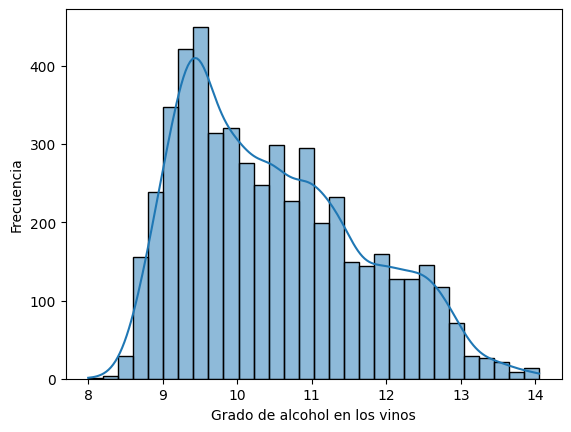

In [7]:
sns.histplot(train_set[target_reg], kde=True)
plt.xlabel('Grado de alcohol en los vinos')
plt.ylabel('Frecuencia')
plt.show()

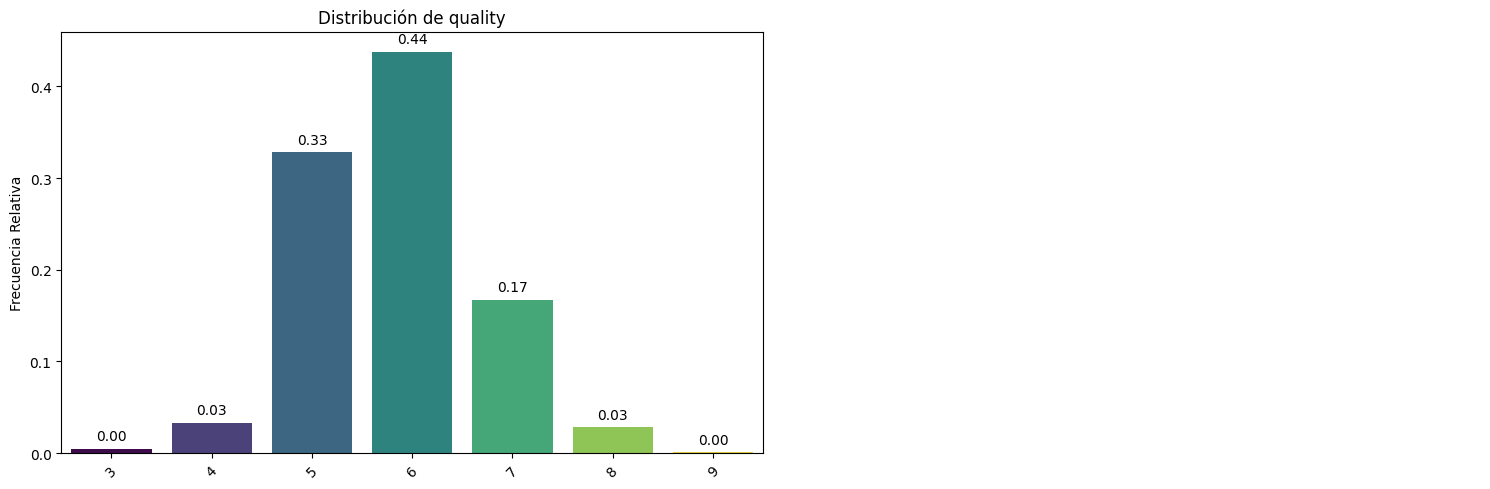

In [8]:
bt.pinta_distribucion_categoricas(train_set, [target_clf], mostrar_valores=True, relativa=True)

In [9]:
train_set.describe().T

count        mean        std      min       25%  \
fixed acidity         5197.0    7.213527   1.293974  3.90000   6.40000   
volatile acidity      5197.0    0.339548   0.162938  0.08000   0.23000   
citric acid           5197.0    0.319244   0.145978  0.00000   0.25000   
residual sugar        5197.0    5.466615   4.783581  0.60000   1.80000   
chlorides             5197.0    0.055733   0.032656  0.01200   0.03800   
free sulfur dioxide   5197.0   30.563306  18.004967  1.00000  17.00000   
total sulfur dioxide  5197.0  115.592457  56.805306  6.00000  76.00000   
density               5197.0    0.994714   0.003012  0.98711   0.99236   
pH                    5197.0    3.219144   0.160025  2.72000   3.11000   
sulphates             5197.0    0.531083   0.147928  0.22000   0.43000   
alcohol               5197.0   10.490439   1.194099  8.00000   9.50000   
quality               5197.0    5.817587   0.870688  3.00000   5.00000   

                           50%      75%        max  
fixed acidity           7.0000    7.700   15.50000  
volatile acidity        0.2900    0.400    1.33000  
citric acid             0.3100    0.400    1.66000  
residual sugar          3.0000    8.100   65.80000  
chlorides               0.0470    0.065    0.61100  
free sulfur dioxide    29.0000   41.000  289.00000  
total sulfur dioxide  118.0000  156.000  440.00000  
density                 0.9949    0.997    1.03898  
pH                      3.2100    3.320    4.01000  
sulphates               0.5100    0.600    1.98000  
alcohol                10.3000   11.300   14.05000  
quality                 6.0000    6.000    9.00000

In [10]:
features_num_clf = [col for col in train_set.columns if col != "class" and col != target_clf]
print(len(features_num_clf))

11


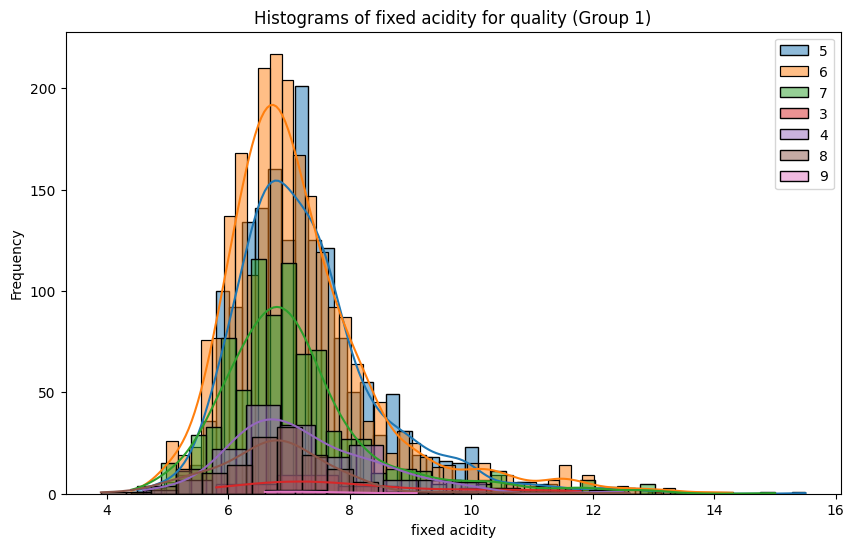

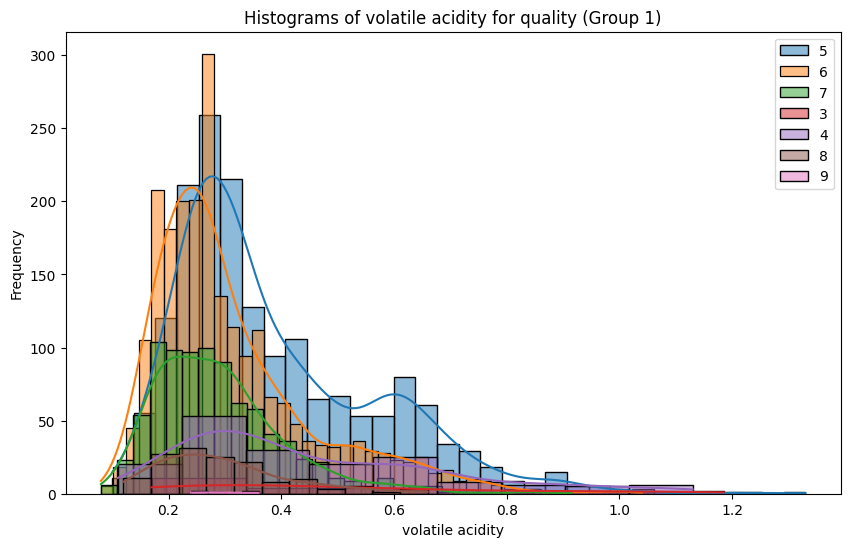

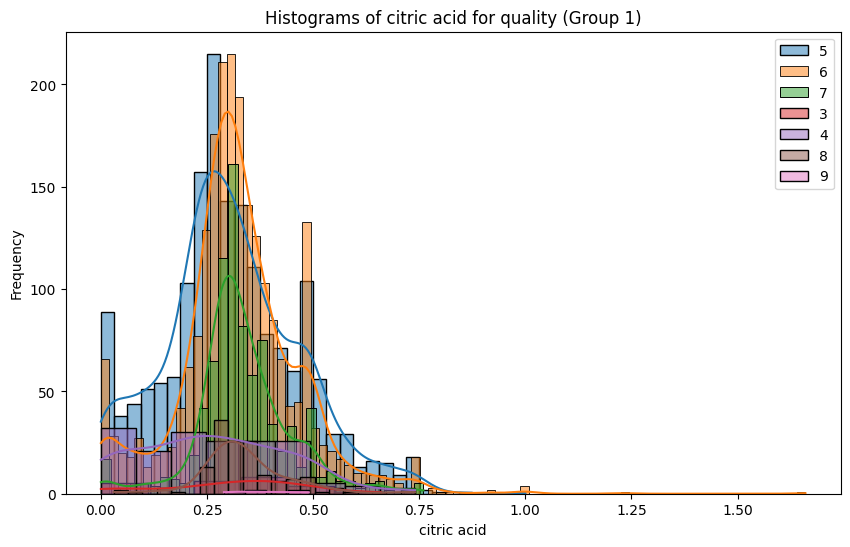

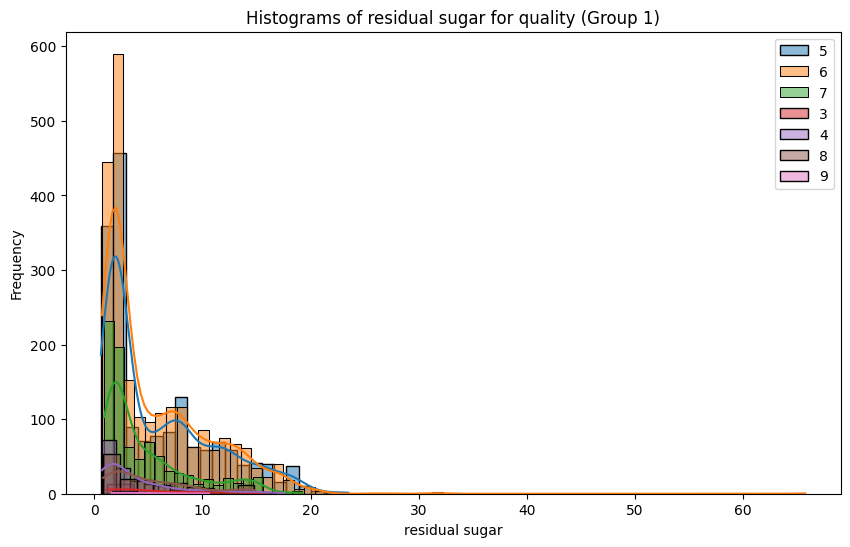

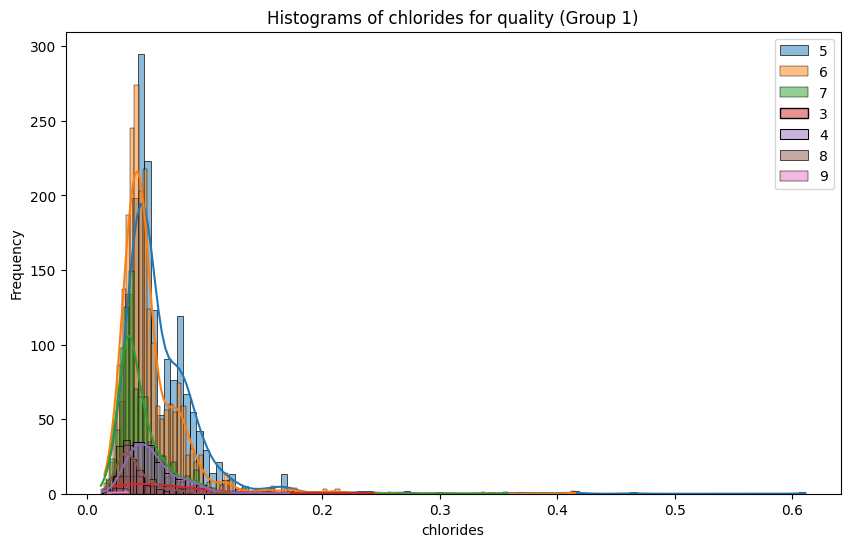

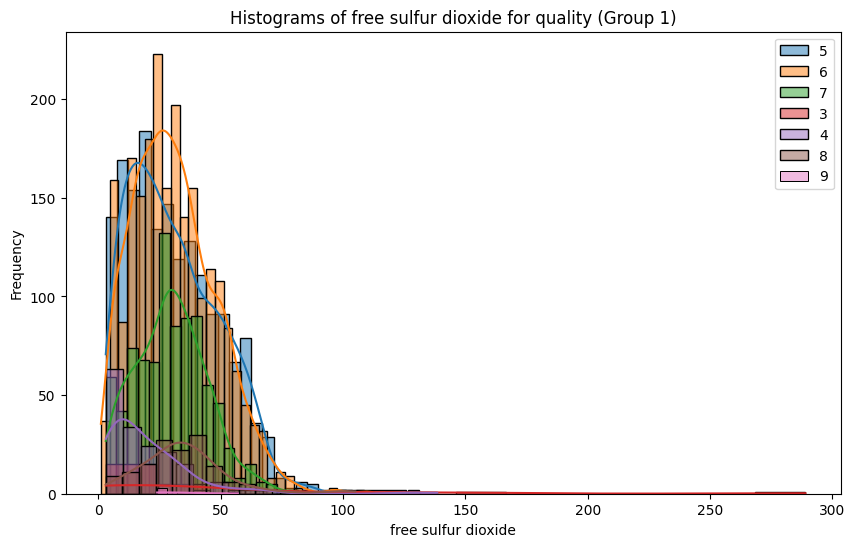

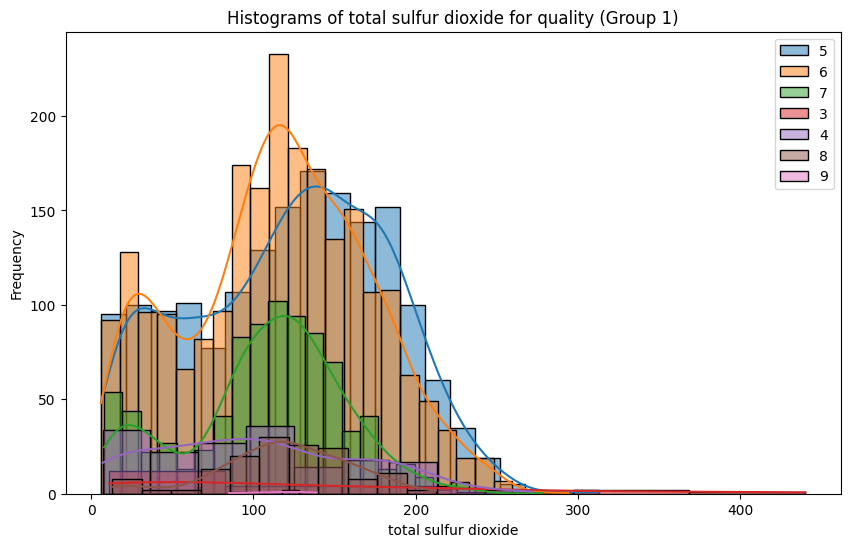

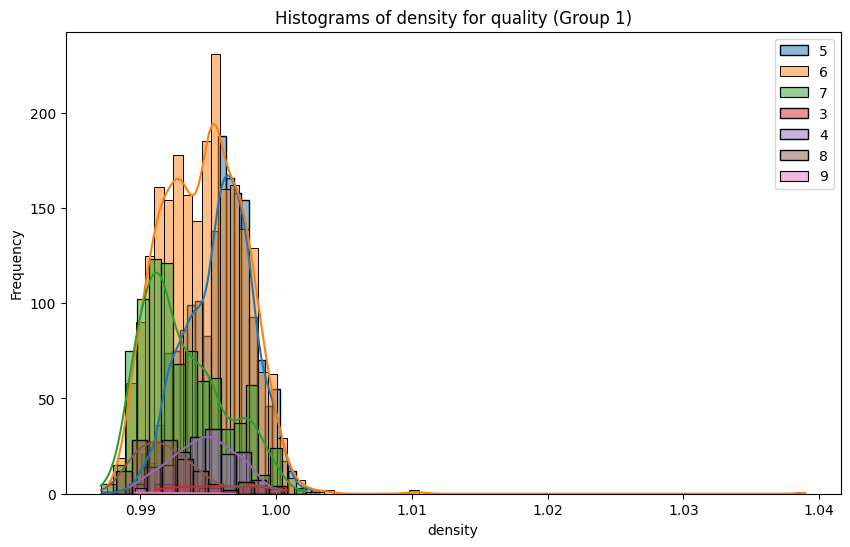

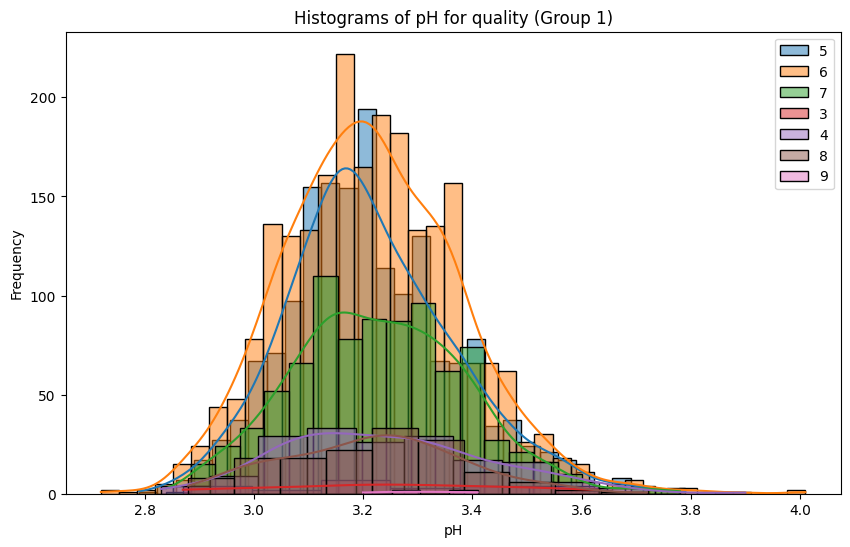

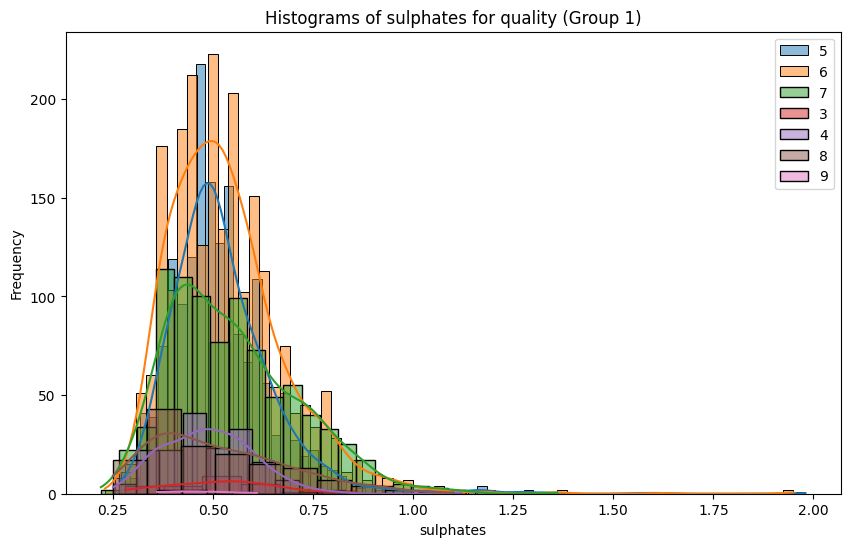

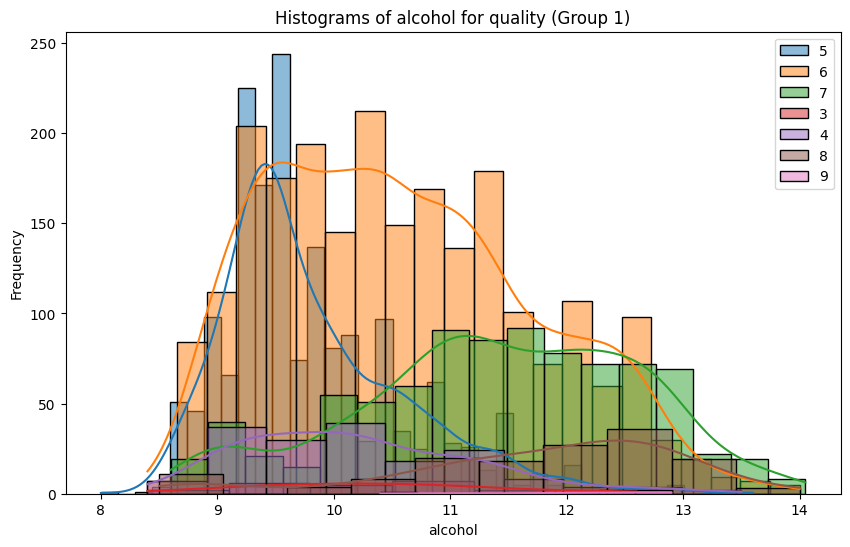

In [11]:
#Analisis numericas vs target

for col in features_num_clf:
    bt.plot_grouped_histograms(train_set, cat_col= target_clf, num_col= col, group_size= train_set[target_clf].nunique())

In [12]:
#Defino variables primarias y secundarias

featues_num_clf_1 = ["volatile acidity","citric acid","chlorides","free sulfur dioxide","total sulfur dioxide", "density","sulphates","alcohol"]
features_num_clf_2 = ["fixed acidity","residual sugar","pH"]

In [13]:
corr = train_set.corr(numeric_only= True)
np.abs(corr[target_clf]).sort_values(ascending = False)

quality                 1.000000
alcohol                 0.450403
density                 0.305107
volatile acidity        0.255368
chlorides               0.197389
citric acid             0.096020
fixed acidity           0.071698
sulphates               0.052398
total sulfur dioxide    0.050816
free sulfur dioxide     0.039678
residual sugar          0.039630
pH                      0.011918
Name: quality, dtype: float64

In [14]:
#train_set['class'] = train_set['class'].replace({'white': 0, 'red': 1})
#test_set['class'] = test_set['class'].replace({'white': 0 , 'red' : 1})

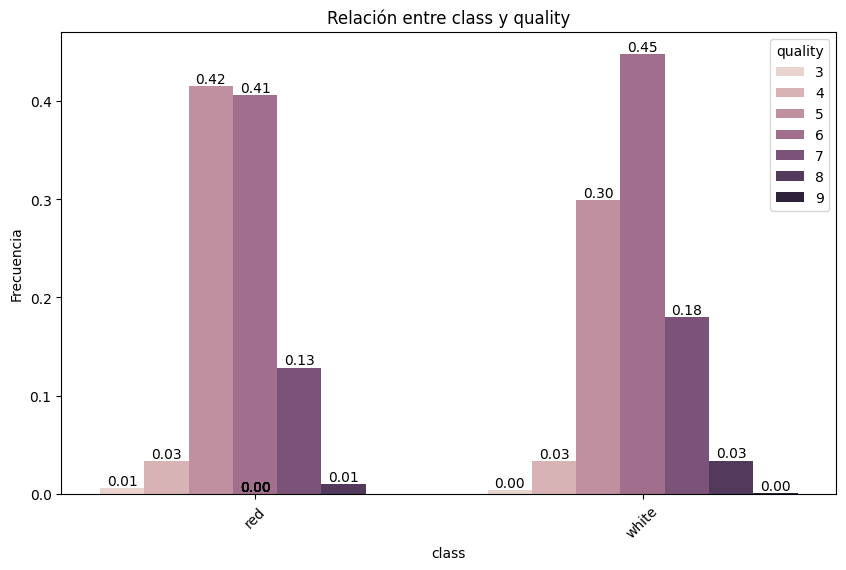

In [15]:
#Analisis categoricas vs target

bt.plot_categorical_relationship_fin(train_set, "class", target_clf, show_values= True, relative_freq= True)


In [16]:
features_cat_clf = ["class"]

In [17]:
print(featues_num_clf_1)
print(features_num_clf_2)
print(features_cat_clf)

['volatile acidity', 'citric acid', 'chlorides', 'free sulfur dioxide', 'total sulfur dioxide', 'density', 'sulphates', 'alcohol']
['fixed acidity', 'residual sugar', 'pH']
['class']


In [18]:
#Mini Eda Regresion

features_cat_reg = ['quality', 'class']

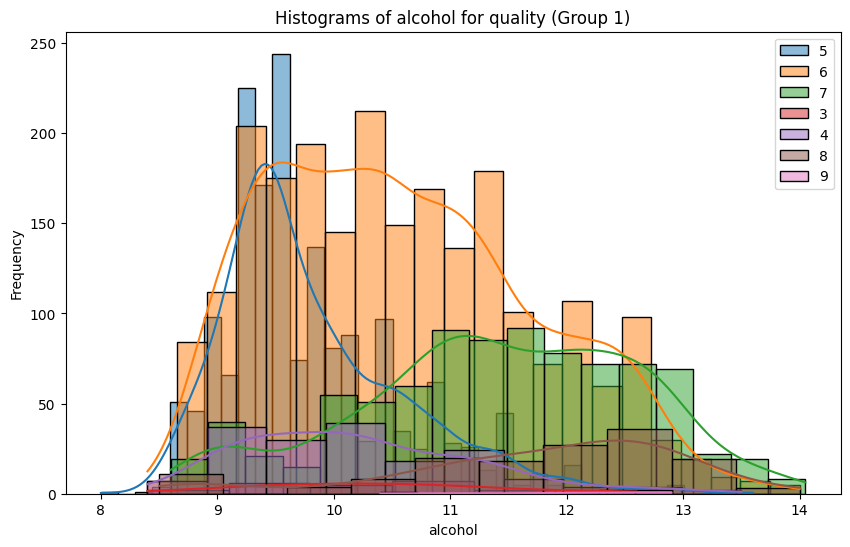

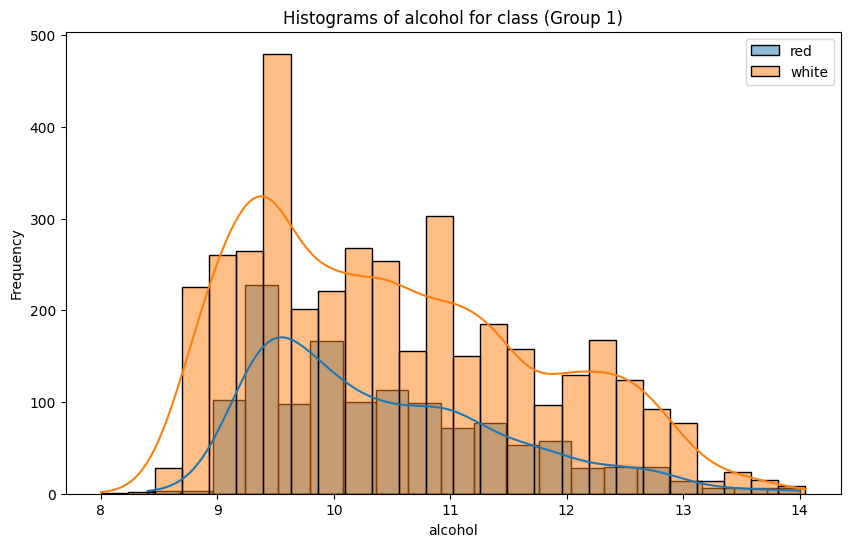

In [19]:
for col in features_cat_reg:
    bt.plot_grouped_histograms(train_set, cat_col= col, num_col= target_reg, group_size= train_set[col].nunique())

In [20]:
features_num_reg = [col for col in train_set.columns if col not in features_cat_reg]
features_num_reg

['fixed acidity',
 'volatile acidity',
 'citric acid',
 'residual sugar',
 'chlorides',
 'free sulfur dioxide',
 'total sulfur dioxide',
 'density',
 'pH',
 'sulphates',
 'alcohol']

In [21]:
corr = train_set[features_num_reg].corr(numeric_only= "True")
serie_corr = np.abs(corr[target_reg]).sort_values(ascending = False)
serie_corr

alcohol                 1.000000
density                 0.682345
residual sugar          0.357459
total sulfur dioxide    0.272970
chlorides               0.260508
free sulfur dioxide     0.188460
pH                      0.116497
fixed acidity           0.091964
volatile acidity        0.036041
citric acid             0.005690
sulphates               0.000412
Name: alcohol, dtype: float64

In [22]:
features_num_reg_1 = []

for feature, corr_value in serie_corr.items():
    if feature != target_reg and corr_value > 0.1:
        features_num_reg_1.append(feature)

print(features_num_reg_1)

['density', 'residual sugar', 'total sulfur dioxide', 'chlorides', 'free sulfur dioxide', 'pH']


<Axes: >

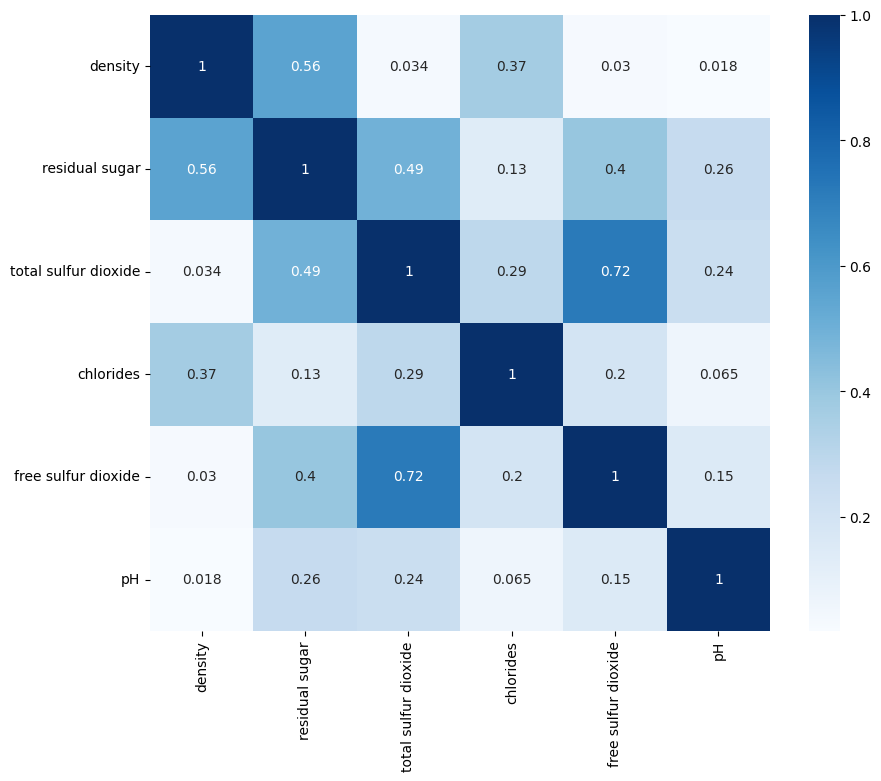

In [23]:
plt.figure(figsize = (10,8))
sns.heatmap(np.abs(train_set[features_num_reg_1].corr(numeric_only= "True")), annot= True, cmap = "Blues")

In [24]:
features_num_reg_1

['density',
 'residual sugar',
 'total sulfur dioxide',
 'chlorides',
 'free sulfur dioxide',
 'pH']

In [25]:
features_num_reg_2 = [col for col in train_set.columns if col not in features_num_reg_1 and col != target_reg
                       and col not in features_cat_reg]

features_num_reg_2

['fixed acidity', 'volatile acidity', 'citric acid', 'sulphates']

In [26]:
features_num_reg_1.remove("free sulfur dioxide")
features_num_reg_2.append("free sulfur dioxide")

In [27]:
#Convierto las categoricas

pd.get_dummies(train_set["class"], columns="class", drop_first=True, dtype=int)

white
1916      0
947       1
877       1
2927      1
6063      0
...     ...
3772      1
5191      1
5226      1
5390      1
860       1

[5197 rows x 1 columns]

In [28]:
train_set["class"] = (train_set["class"] == "white").astype(int)
test_set["class"] = (test_set["class"] == "white").astype(int) 

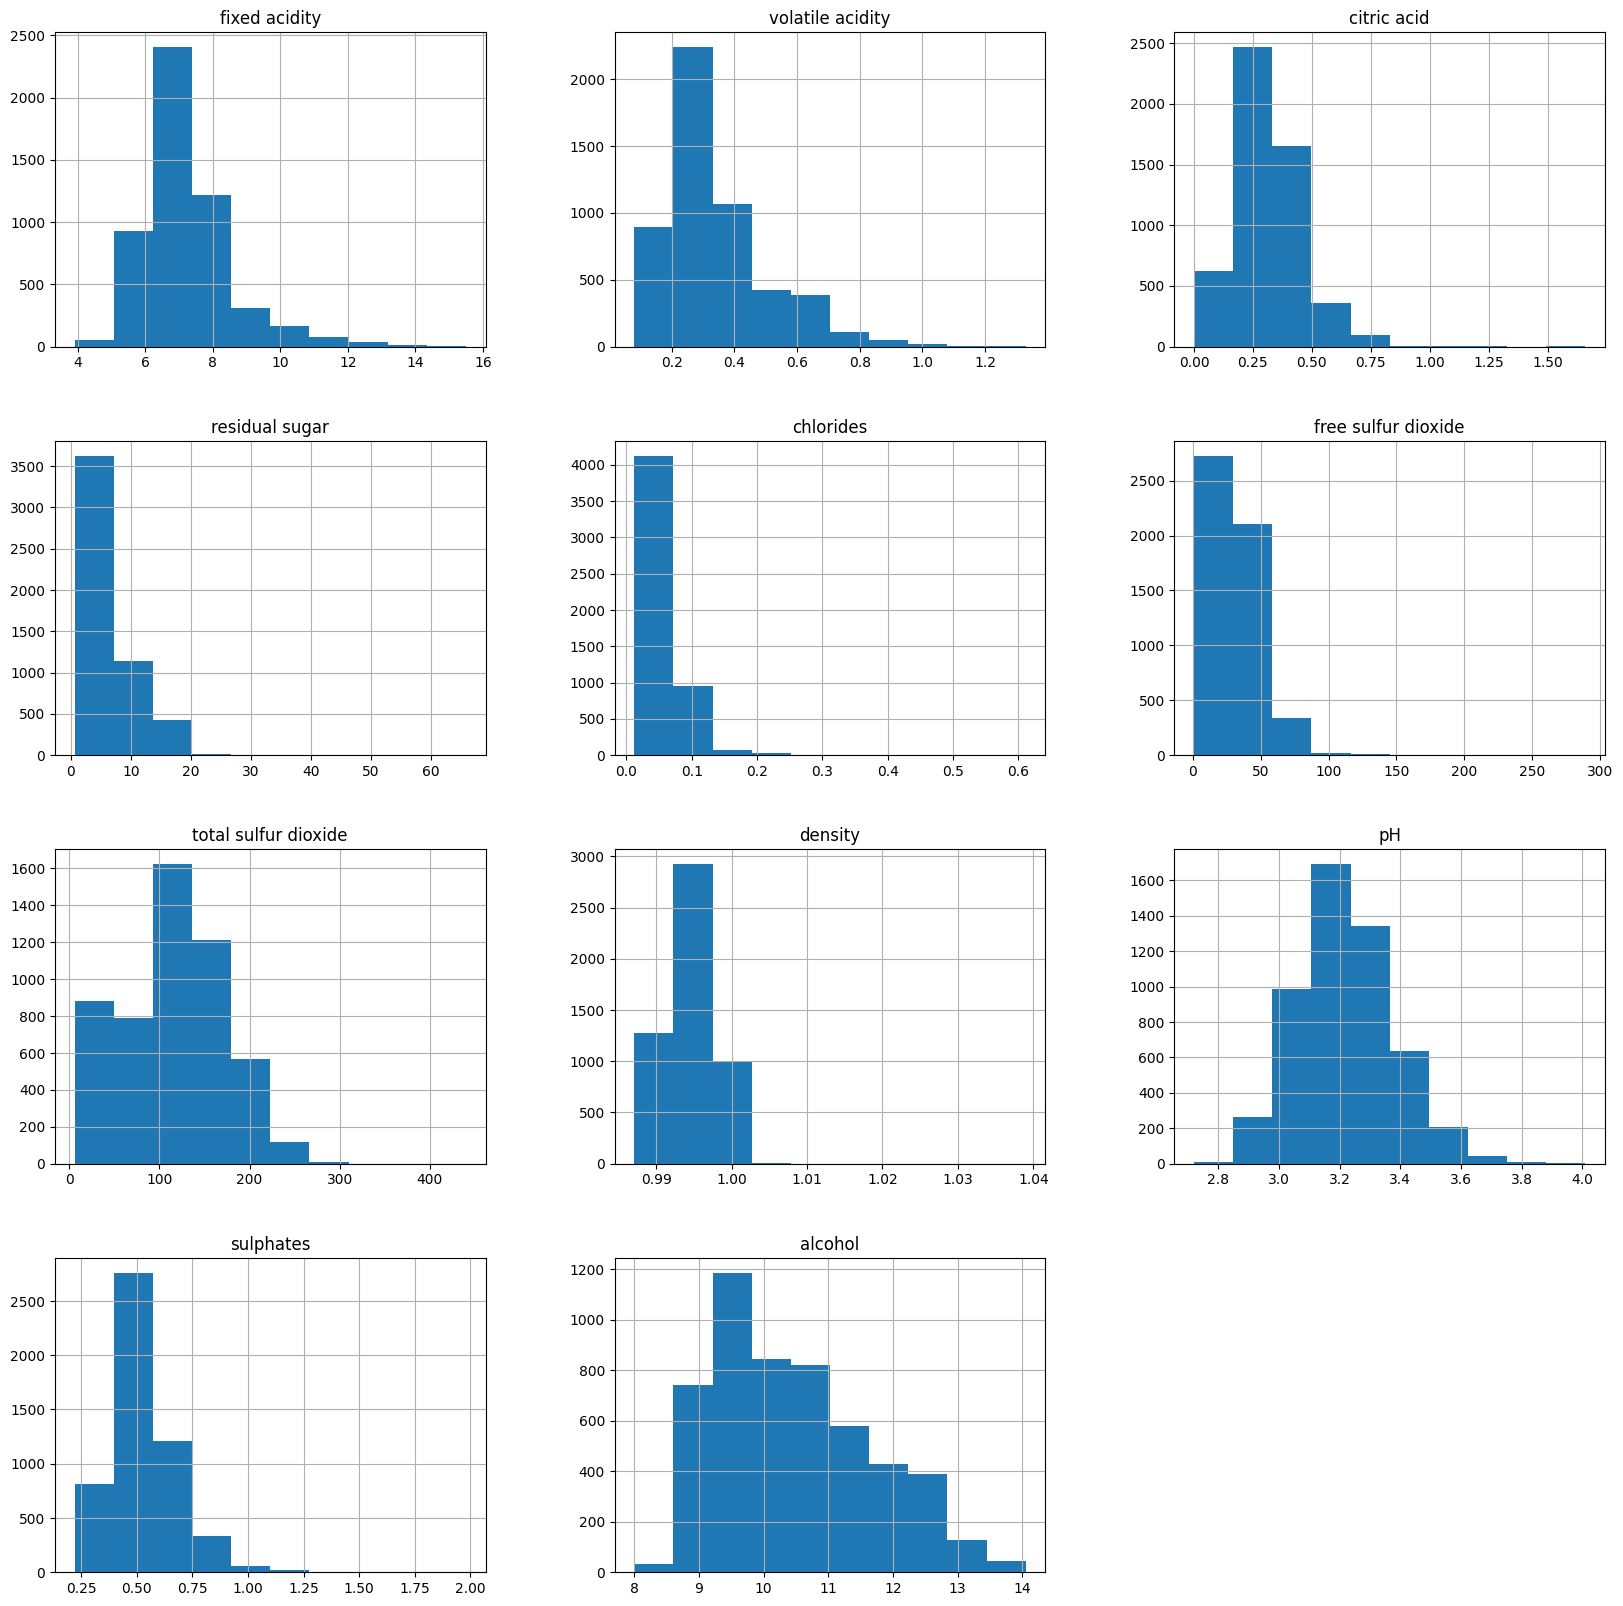

In [29]:
train_set[features_num_clf].hist(figsize = (20,20))
plt.tight_layout
plt.show()

In [30]:
np.log1p(train_set["citric acid"])

1916    0.336472
947     0.553885
877     0.215111
2927    0.246860
6063    0.343590
          ...   
3772    0.405465
5191    0.246860
5226    0.322083
5390    0.254642
860     0.246860
Name: citric acid, Length: 5197, dtype: float64

In [31]:
train_set_scaled = train_set.copy()
test_set_scaled = test_set.copy()

In [32]:
features_to_transform = [
    "fixed acidity",
    "volatile acidity",
    "citric acid",
    "residual sugar", 
    "chlorides",
    "free sulfur dioxide", 
    "total sulfur dioxide",
    "sulphates"
    ]

In [33]:
for col in features_to_transform:
    desplaza = 0
    if train_set_scaled[col].min() <= 0:
        desplaza = int(abs(train_set_scaled[col].min())) + 1
    train_set_scaled[col] = np.log(train_set_scaled[col] + desplaza)
    test_set_scaled[col] = np.log(test_set_scaled[col] + desplaza)

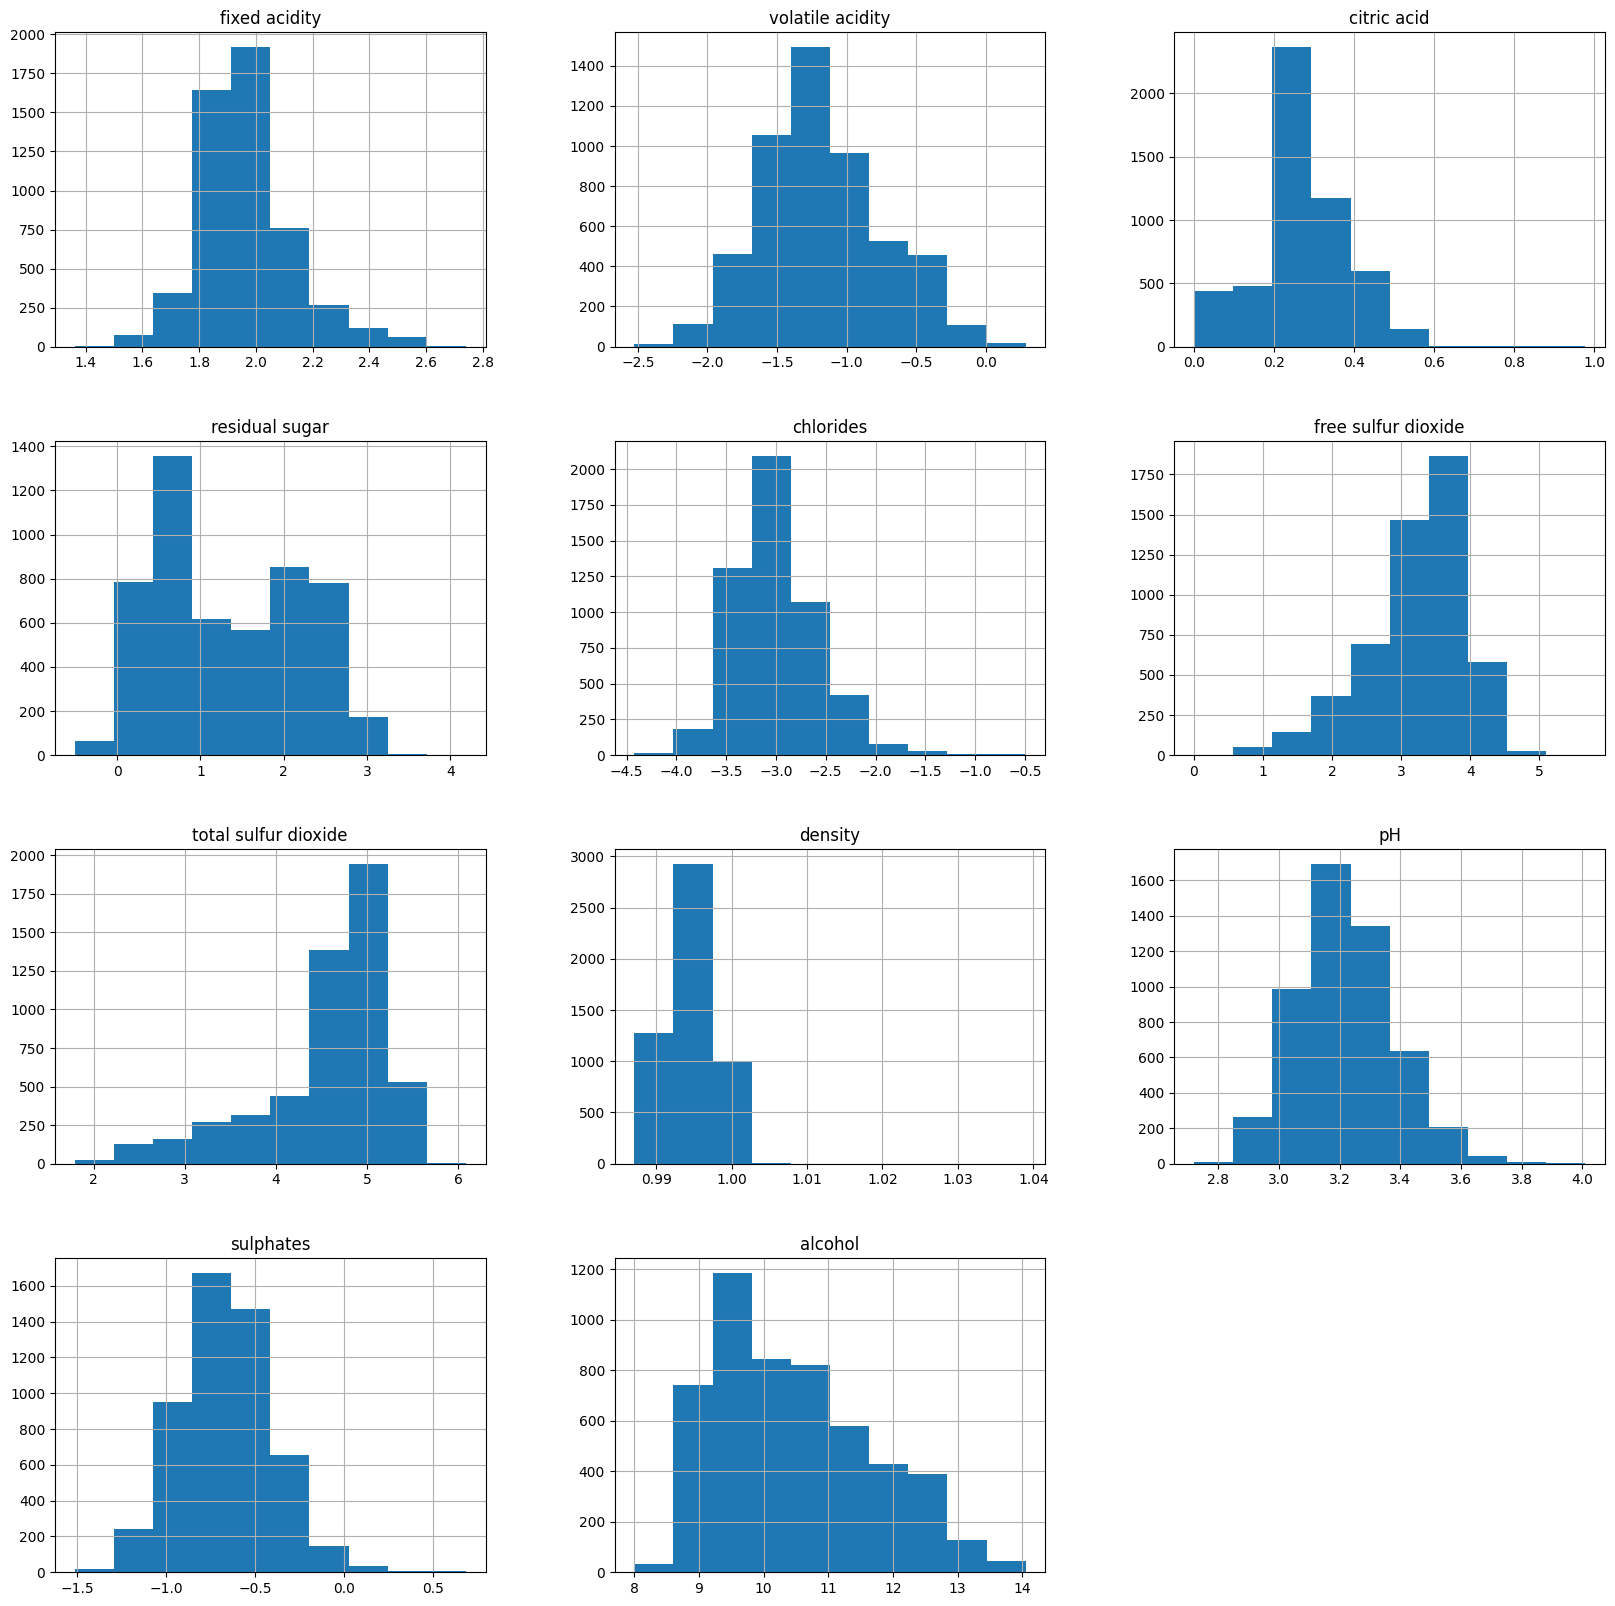

In [34]:
train_set_scaled[features_num_clf].hist(figsize = (20,20))
plt.tight_layout
plt.show()

In [35]:
features_num_clf

['fixed acidity',
 'volatile acidity',
 'citric acid',
 'residual sugar',
 'chlorides',
 'free sulfur dioxide',
 'total sulfur dioxide',
 'density',
 'pH',
 'sulphates',
 'alcohol']

In [36]:
scaler = StandardScaler()

features_num_reg = features_num_clf.copy()
features_num_reg.remove("alcohol")

train_set_scaled[features_num_reg] = scaler.fit_transform(train_set_scaled[features_num_reg])
test_set_scaled[features_num_reg] = scaler.transform(test_set_scaled[features_num_reg])

In [37]:
train_set_scaled[features_num_reg].describe()

fixed acidity  volatile acidity   citric acid  residual sugar  \
count   5.197000e+03      5.197000e+03  5.197000e+03    5.197000e+03   
mean   -5.605590e-16     -2.214892e-16  7.656416e-17    2.734434e-18   
std     1.000096e+00      1.000096e+00  1.000096e+00    1.000096e+00   
min    -3.650546e+00     -3.093987e+00 -2.452808e+00   -2.130418e+00   
25%    -6.406275e-01     -6.678919e-01 -4.329462e-01   -8.590345e-01   
50%    -9.608146e-02     -1.353685e-01 -8.563028e-03   -2.678746e-01   
75%     4.830897e-01      6.034131e-01  5.928880e-01    8.815795e-01   
max     4.734467e+00      3.363578e+00  6.402853e+00    3.305764e+00   

          chlorides  free sulfur dioxide  total sulfur dioxide       density  \
count  5.197000e+03         5.197000e+03          5.197000e+03  5.197000e+03   
mean   5.714968e-16        -1.709021e-16          1.668005e-16  5.706764e-14   
std    1.000096e+00         1.000096e+00          1.000096e+00  1.000096e+00   
min   -3.375535e+00        -4.578518e+00         -3.851433e+00 -2.524538e+00   
25%   -6.595501e-01        -5.432713e-01         -3.193079e-01 -7.815705e-01   
50%   -1.587052e-01         2.174037e-01          2.927357e-01  6.169387e-02   
75%    6.052801e-01         7.105928e-01          6.811085e-01  7.588809e-01   
max    5.884922e+00         3.491975e+00          2.123631e+00  1.469598e+01   

                 pH     sulphates  
count  5.197000e+03  5.197000e+03  
mean   2.365286e-16 -8.169122e-17  
std    1.000096e+00  1.000096e+00  
min   -3.119464e+00 -3.303529e+00  
25%   -6.821081e-01 -6.902881e-01  
50%   -5.714499e-02 -2.494373e-02  
75%    6.303145e-01  6.087895e-01  
max    4.942560e+00  5.264422e+00

In [38]:
train_set_scaled_clf = train_set_scaled.copy()
test_set_scaled_clf = test_set_scaled.copy()

train_set_scaled_clf["alcohol"] = scaler.fit_transform(train_set_scaled_clf[["alcohol"]])
test_set_scaled_clf["alcohol"] = scaler.transform(test_set_scaled_clf[["alcohol"]])

In [39]:
y_train_clf = train_set[target_clf]
y_test_clf = test_set[target_clf]
y_train_reg = train_set[target_reg]
y_test_reg = test_set[target_reg]


X_train_clf_dict = {}
X_test_clf_dict = {}

X_train_reg_dict = {}
X_test_reg_dict = {}

# Juegos X_train clasificacion

features_set_name = ["cat+num_1", "todas"]
features_set = [features_cat_clf + featues_num_clf_1,
                features_cat_clf + featues_num_clf_1 + features_num_clf_2]


for set_name,feature_list in zip(features_set_name, features_set):
    print(feature_list)
    X_train_clf_dict[set_name] = train_set_scaled_clf[feature_list]
    X_test_clf_dict[set_name] = test_set_scaled_clf[feature_list]

# Juegos X_train regresion
    
features_set_name = ["cat+num_1","todas"]
features_set = [features_cat_reg + features_num_reg_1,
                features_cat_reg + features_num_reg_1 + features_num_reg_2]

for set_name,feature_list in zip(features_set_name, features_set):
    print(feature_list)
    X_train_reg_dict[set_name] = train_set_scaled[feature_list]
    X_test_reg_dict[set_name] = test_set_scaled[feature_list]

['class', 'volatile acidity', 'citric acid', 'chlorides', 'free sulfur dioxide', 'total sulfur dioxide', 'density', 'sulphates', 'alcohol']
['class', 'volatile acidity', 'citric acid', 'chlorides', 'free sulfur dioxide', 'total sulfur dioxide', 'density', 'sulphates', 'alcohol', 'fixed acidity', 'residual sugar', 'pH']
['quality', 'class', 'density', 'residual sugar', 'total sulfur dioxide', 'chlorides', 'pH']
['quality', 'class', 'density', 'residual sugar', 'total sulfur dioxide', 'chlorides', 'pH', 'fixed acidity', 'volatile acidity', 'citric acid', 'sulphates', 'free sulfur dioxide']


In [40]:

knn_clf = KNeighborsClassifier(n_neighbors= 5)
knn_ten_clf = KNeighborsClassifier(n_neighbors= 10)
lr_clf = LogisticRegression(max_iter = 1000)
rf_clf = RandomForestClassifier(max_depth = 10, random_state= 42)
lgb_clf = LGBMClassifier(max_depth = 10, random_state = 42, verbose = -100, n_jobs= -1)

modelos_clf = {
    "KNN_5": knn_clf,
    "KNN_10": knn_ten_clf,
    "Regresion Logistica": lr_clf,
    "Random Forest": rf_clf,
    "LightGBM": lgb_clf
}

In [41]:
for feature_set, X_train in X_train_clf_dict.items():
    print(f"Para el set {feature_set}:")
    for tipo,modelo in modelos_clf.items():
        print(f"{tipo}: ", end = " ")
        print(np.mean(cross_val_score(modelo, X_train, y_train_clf, cv = 5, scoring = "balanced_accuracy")))
    print("******")

Para el set cat+num_1:
KNN_5:  0.2656152390156306
KNN_10:  0.24473064132531913
Regresion Logistica:  0.22451669552179068
Random Forest:  0.2738181185046397
LightGBM:  0.33312050630396667
******
Para el set todas:
KNN_5:  0.2626256925203968
KNN_10:  0.24377920201901465
Regresion Logistica:  0.22768844791931478
Random Forest:  0.27464335447341287
LightGBM:  0.3371484312539852
******


In [42]:

knn_clf = KNeighborsClassifier(n_neighbors= 5, weights= "distance")
knn_ten_clf = KNeighborsClassifier(n_neighbors= 10, weights = "distance")
lr_clf = LogisticRegression(max_iter = 1000, class_weight = "balanced")
rf_clf = RandomForestClassifier(max_depth = 10, random_state= 42, class_weight = "balanced")
lgb_clf = LGBMClassifier(max_depth = 10, random_state = 42, verbose = -100, class_weight = "balanced", n_jobs=-1)

modelos_clf = {
    "KNN_5": knn_clf,
    "KNN_10": knn_ten_clf,
    "Regresion Logistica": lr_clf,
    "Random Forest": rf_clf,
    "LightGBM": lgb_clf
}

In [43]:
for feature_set, X_train in X_train_clf_dict.items():
    print(f"Para el set {feature_set}:")
    for tipo,modelo in modelos_clf.items():
        print(f"{tipo}: ", end = " ")
        print(np.mean(cross_val_score(modelo, X_train, y_train_clf, cv = 5, scoring = "balanced_accuracy")))
    print("******")

Para el set cat+num_1:
KNN_5:  0.3438180414446099
KNN_10:  0.3332100205551276
Regresion Logistica:  0.28995872116553434
Random Forest:  0.3544769911973666
LightGBM:  0.3560814306068496
******
Para el set todas:
KNN_5:  0.3423482427183459
KNN_10:  0.3362180100381279
Regresion Logistica:  0.3845352978775572
Random Forest:  0.34149748580207673
LightGBM:  0.35958149480776325
******


In [46]:
param_grid = {
    "C": [0.01, 0.1, 1, 10, 100],
    "penalty": ["l1", "l2"],
    "class_weight": ["balanced", None],
    "solver": ["liblinear"]  # compatible con l1 y l2
}

logreg = LogisticRegression(max_iter=1000, random_state=42)

logreg_grid = GridSearchCV(logreg,
                           param_grid=param_grid,
                           cv=5,
                           scoring="balanced_accuracy",
                           n_jobs=-1)

logreg_grid.fit(X_train_clf_dict["todas"], y_train_clf)

print("Mejores hiperparámetros:", logreg_grid.best_params_)
print("Mejor balanced accuracy:", logreg_grid.best_score_)

Mejores hiperparámetros: {'C': 1, 'class_weight': 'balanced', 'penalty': 'l1', 'solver': 'liblinear'}
Mejor balanced accuracy: 0.37253254418202586


In [48]:
y_pred = logreg_grid.best_estimator_.predict(X_test_clf_dict["todas"])
print(classification_report(y_test_clf, y_pred, zero_division= 0.0))

              precision    recall  f1-score   support

           3       0.03      0.33      0.05         6
           4       0.14      0.26      0.18        43
           5       0.60      0.58      0.59       432
           6       0.55      0.44      0.49       562
           7       0.36      0.31      0.34       210
           8       0.11      0.19      0.14        47
           9       0.00      0.00      0.00         0

    accuracy                           0.45      1300
   macro avg       0.26      0.30      0.25      1300
weighted avg       0.50      0.45      0.47      1300



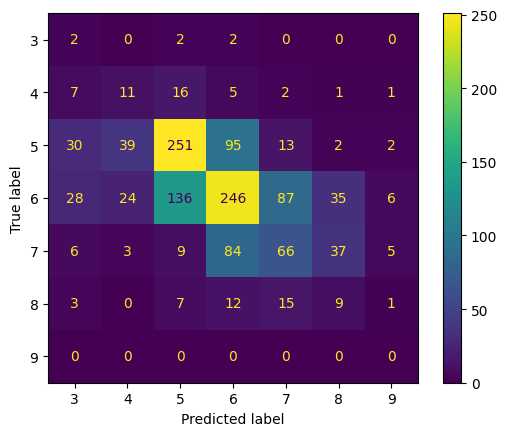

In [51]:
ConfusionMatrixDisplay.from_predictions(y_test_clf, y_pred)
plt.show()

El modelo funciona relativamente bien para las clases más frecuentes (5 y 6), pero mal para las minoritarias (3,4,7,8).

Hay un claro problema de desbalance de clases y el modelo no predice bien las clases raras.

Propondria agrupar las clases que el modelo tiene dificultad para predecir:
- Las 3 y 4 = 'Baja Calidad'
- Las 5 y 6 = 'Calidad Media'
- Las 7, 8 y 9 = 'Alta Calidad'

### #3 Modelado para regresión

Reutiliza todo lo que puedas la preparación del modelado de la parte anterior y construye ahora el mejor modelo que puedas para predecir el grado alcohólico de un vino dadas sus características fisico químicas, su clase y la puntuación de calidad que le ha sido otorgada. Compara al menos tres tipos de modelos, seleccionando una métrica adecuada de comparación y escoge el más apropiado empleando validación cruzada antes o después de optimizar hiperparámetros (en la sesión en vivo lo haremos antes por cuestiones de tiempo). Evalúa el modelo escogido y con los hiperparámetros ajustados de la mejor manera que puedas. Para terminar realizar un pequeño análisis de errores.

In [54]:
rf_reg = RandomForestRegressor(max_depth = 10, random_state= 42)
lgb_reg = LGBMRegressor(max_depth = 10, random_state = 42, verbose = -100)
xgb_reg = XGBRegressor(max_depth = 10, random_state = 42)

modelos_reg = {
    "Random Forest": rf_reg,
    "LightGBM": lgb_reg,
    "XGBoost Regressor": xgb_reg
}

In [55]:
for feature_set, X_train in X_train_reg_dict.items():
    print(f"Para el set {feature_set}:")
    for tipo,modelo in modelos_reg.items():
        print(f"{tipo}: ", end = " ")
        print(-np.mean(cross_val_score(modelo, X_train, y_train_reg, cv = 5, scoring = "neg_mean_absolute_percentage_error")))
    print("******")

Para el set cat+num_1:
Random Forest:  0.036194311832299556
LightGBM:  0.035972036701112875
XGBoost Regressor:  0.031413807321826616
******
Para el set todas:
Random Forest:  0.030762111444869178
LightGBM:  0.02668719056406977
XGBoost Regressor:  0.024487997884411163
******


In [56]:
param_grid = {
    "n_estimators": [100,200,1000],
    "max_depth": [1,5,10,20],
    "max_features": ["log2","sqrt", None]
}

rf_reg = RandomForestRegressor()

rf_grid = GridSearchCV(rf_reg,
                       param_grid= param_grid,
                       cv = 5,
                       scoring = "neg_mean_absolute_percentage_error",
                       n_jobs= -1)

rf_grid.fit(X_train_reg_dict["todas"], y_train_reg)

/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/joblib/externals/loky/process_executor.py:782: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


GridSearchCV(cv=5, estimator=RandomForestRegressor(), n_jobs=-1,
             param_grid={'max_depth': [1, 5, 10, 20],
                         'max_features': ['log2', 'sqrt', None],
                         'n_estimators': [100, 200, 1000]},
             scoring='neg_mean_absolute_percentage_error')

In [57]:
print(rf_grid.best_params_)
print(rf_grid.best_score_)


{'max_depth': 20, 'max_features': None, 'n_estimators': 1000}
-0.02665471576756162


In [58]:
y_pred = rf_grid.best_estimator_.predict(X_test_reg_dict["todas"])
print("MAPE:", mean_absolute_percentage_error(y_test_reg, y_pred))

MAPE: 0.02480746959683647


In [59]:

def plot_predictions_vs_actual(y_real, y_pred):
    """
    Función para graficar los valores reales vs. los valores predichos en una regresión.

    Args:
    y_real (array-like): Valores reales de la variable objetivo.
    y_pred (array-like): Valores predichos de la variable objetivo.
    """
    plt.figure(figsize=(8, 6))
    plt.scatter(y_pred, y_real, alpha=0.5)
    plt.xlabel("Valores Predichos")
    plt.ylabel("Valores Reales")

    # Línea y=x
    max_value = max(max(y_real), max(y_pred))
    min_value = min(min(y_real), min(y_pred))
    plt.plot([min_value, max_value], [min_value, max_value], 'r')

    plt.title("Comparación de Valores Reales vs. Predichos")
    plt.show()

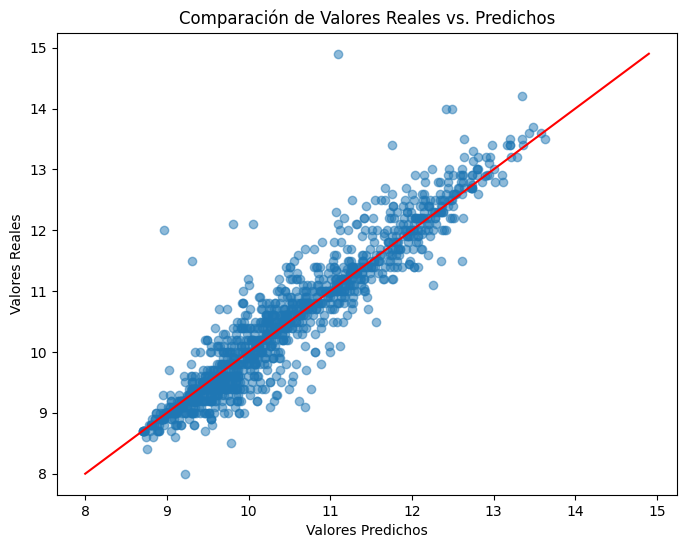

In [60]:
plot_predictions_vs_actual(y_test_reg, y_pred)

In [61]:
pd.DataFrame({"features": rf_grid.best_estimator_.feature_names_in_ , "importance": rf_grid.best_estimator_.feature_importances_}).sort_values("importance",ascending=False)

features  importance
2                density    0.603753
3         residual sugar    0.097225
4   total sulfur dioxide    0.052423
1                  class    0.039417
5              chlorides    0.039042
7          fixed acidity    0.037287
6                     pH    0.029656
9            citric acid    0.028183
10             sulphates    0.021971
8       volatile acidity    0.020147
0                quality    0.019425
11   free sulfur dioxide    0.011473